# Trabalho Final

> Aluno: Pedro Henrique de Amaral Lira

> Email: phal@cesar.school

> Link dataset: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small/data


# 1) Dependências e configuração


In [ ]:
 !pip install -q kaggle torchvision torchaudio torch matplotlib scikit-learn pandas pillow


## 1.1 - Configurar o token do Kaggle

In [ ]:
import os
from pathlib import Path

DATA_DIR = Path('data')
DATA_DIR.mkdir(exist_ok=True)

from google.colab import files
files.upload()
!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json



## 2) Download do Dataset via Kaggle API

In [ ]:
import subprocess

KAGGLE_DATASET = 'paramaggarwal/fashion-product-images-small'
ZIP_PATH = DATA_DIR / 'fashion-product-images-small.zip'
EXTRACT_DIR = DATA_DIR / 'fashion-product-images-small'

if not EXTRACT_DIR.exists():
    try:
        print('Tentando baixar dataset do Kaggle...')
        subprocess.run(['kaggle', 'datasets', 'download', '-d', KAGGLE_DATASET, '-p', str(DATA_DIR), '--unzip'], check=True)
        print('Download e unzip concluídos.')
    except Exception as e:
        print('Falha ao baixar via kaggle CLI. Verifique se kaggle.json está configurado. Erro:', e)
else:
    print('Dataset já disponível em', EXTRACT_DIR)



Tentando baixar dataset do Kaggle...
Download e unzip concluídos.



# 3) Exploração rápida e carregamento


In [ ]:
import os
from pathlib import Path

for root, dirs, files in os.walk(EXTRACT_DIR):
    level = root.replace(str(EXTRACT_DIR), '').count(os.sep)
    if level == 0:
        print('Conteúdo principal:')
    if level <= 1:
        print(' -', os.path.basename(root), '->', len(files), 'arquivos')

IMAGE_DIR = None

nested_dataset_folder_name = KAGGLE_DATASET.split('/')[-1]

candidate_paths = [
    EXTRACT_DIR / 'images',
    DATA_DIR / 'images',
    EXTRACT_DIR / 'images' / 'images',
    EXTRACT_DIR / nested_dataset_folder_name / 'images',
    EXTRACT_DIR
]

for candidate in candidate_paths:
    if candidate.exists():

        imgs = list(candidate.rglob('*.jpg')) + list(candidate.rglob('*.jpeg')) + list(candidate.rglob('*.png'))
        if len(imgs) > 0:
            IMAGE_DIR = candidate
            break

if IMAGE_DIR is None:
    raise FileNotFoundError('Não foi possível encontrar imagens no diretório extraído. Verifique estrutura do dataset.')
else:
    print('Imagens encontradas em:', IMAGE_DIR)

Imagens encontradas em: data/images



## 4) Preparar dataset para treino (PyTorch)
 - Vamos criar um dataset simples que lê imagens, aplica transforms, e usa a coluna 'category' (quando disponível) como rótulo.
 - Para simplificar aqui usaremos: carregar N classes mais frequentes para evitar desequilíbrio e reduzir custo computacional.


In [ ]:
import pandas as pd
from collections import Counter
from pathlib import Path

csv_candidates = list(DATA_DIR.rglob('*.csv'))
print('CSV encontrados:', csv_candidates)

labels_df = None
labels_csv = None
for csv in csv_candidates:
    try:
        df = pd.read_csv(csv, on_bad_lines='skip')
        print(f"Colunas para {csv}: {df.columns.tolist()}")
        if 'id' in df.columns and any(col in df.columns for col in ['masterCategory', 'subCategory', 'articleType', 'category']):
            labels_df = df
            labels_csv = csv
            break
    except Exception as e:
        print(f"Erro ao ler {csv} ou verificar colunas: {e}")
        continue

if labels_df is None:
    print('Nenhum CSV com rótulos encontrado ou colunas esperadas ausentes. Iremos construir rótulos a partir do nome de diretórios (se houver).')
else:
    print('Usando CSV de rótulos:', labels_csv)
    print(labels_df.columns)

image_list = list(IMAGE_DIR.rglob('*.jpg')) + list(IMAGE_DIR.rglob('*.jpeg')) + list(IMAGE_DIR.rglob('*.png'))
image_names = {p.name: p for p in image_list}
print('Total imagens encontradas:', len(image_list))

rows = []
if labels_df is not None:
    possible_label_cols = [c for c in ['masterCategory', 'subCategory', 'articleType', 'category', 'label', 'gender'] if c in labels_df.columns]
    label_col = possible_label_cols[0] if possible_label_cols else None

    possible_image_cols = [c for c in ['id', 'image', 'filename'] if c in labels_df.columns]
    image_col = possible_image_cols[0] if possible_image_cols else None

    if image_col is None:
        print('Não foi possível identificar coluna de imagem no CSV; iremos usar lista de imagens encontrada.')
    else:
        for _, r in labels_df.iterrows():
            img_id = str(r[image_col])
            img_name = f"{img_id}.jpg"

            if img_name in image_names:
                label = r[label_col] if label_col is not None else 'unknown'
                rows.append({'image_path': str(image_names[img_name]), 'label': str(label)})
            else:
                img_path_from_id = IMAGE_DIR / f"{img_id}"
                if img_path_from_id.exists() and img_path_from_id in image_names.values():
                    label = r[label_col] if label_col is not None else 'unknown'
                    rows.append({'image_path': str(img_path_from_id), 'label': str(label)})
                elif Path(img_id).suffix in ['.jpg', '.jpeg', '.png'] and img_id in image_names:
                    label = r[label_col] if label_col is not None else 'unknown'
                    rows.append({'image_path': str(image_names[img_id]), 'label': str(label)})

if not rows:
    print('Atenção: Não foi possível carregar rótulos do CSV ou nomes de arquivo. Usando nomes de diretório como rótulos.')
    for p in image_list:
        parent = p.parent.name
        rows.append({'image_path': str(p), 'label': parent})

labels_df_final = pd.DataFrame(rows)
print('Total imagens com rótulo preparadas:', len(labels_df_final))
print(labels_df_final['label'].value_counts().head())

CSV encontrados: [PosixPath('data/styles.csv'), PosixPath('data/myntradataset/styles.csv')]
Colunas para data/styles.csv: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName']
Usando CSV de rótulos: data/styles.csv
Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')
Total imagens encontradas: 44441
Total imagens com rótulo preparadas: 44419
label
Apparel          21392
Accessories      11274
Footwear          9219
Personal Care     2403
Free Items         105
Name: count, dtype: int64


## 4.1 - Selecionar as top-K classes mais frequentes para simplificar
 (reduz custo de treino e facilita interpretação)

In [ ]:
TOP_K = 10
top_labels = labels_df_final['label'].value_counts().nlargest(TOP_K).index.tolist()
labels_df_final = labels_df_final[labels_df_final['label'].isin(top_labels)].reset_index(drop=True)
labels_df_final['label_id'] = labels_df_final['label'].astype('category').cat.codes
label_mapping = dict(enumerate(labels_df_final['label'].astype('category').cat.categories))
print('Classes usadas (top {}):'.format(TOP_K), label_mapping)
num_classes = len(label_mapping)


Classes usadas (top 10): {0: 'Accessories', 1: 'Apparel', 2: 'Footwear', 3: 'Free Items', 4: 'Home', 5: 'Personal Care', 6: 'Sporting Goods'}


# 5) Criar PyTorch Dataset e DataLoader


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms

IMG_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class FashionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            img = Image.open(row['image_path']).convert('RGB')
        except Exception as e:
            return None, None

        if self.transform:
            img = self.transform(img)
        label = int(row['label_id'])
        return img, label

def collate_fn_filtered(batch):
    batch = list(filter(lambda x: x[0] is not None, batch))
    if not batch:
        return torch.tensor([]), torch.tensor([])
    return torch.utils.data.dataloader.default_collate(batch)

full_dataset = FashionDataset(labels_df_final, transform=transform)

val_frac = 0.1
test_frac = 0.1
n = len(full_dataset)
val_n = int(n * val_frac)
test_n = int(n * test_frac)
train_n = n - val_n - test_n
train_set, val_set, test_set = random_split(full_dataset, [train_n, val_n, test_n], generator=torch.Generator().manual_seed(42))

BATCH_SIZE = 32
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collate_fn_filtered)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn_filtered)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn_filtered)

print('Tamanhos -> train:', len(train_set), 'val:', len(val_set), 'test:', len(test_set))


Tamanhos -> train: 35537 val: 4441 test: 4441


# 6) Definir o modelo (CNN simples)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * (IMG_SIZE//8) * (IMG_SIZE//8), 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.4)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_classes).to(device)
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


# 7) Treinamento

In [ ]:
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 5
BATCH_SIZE = 16
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collate_fn_filtered)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn_filtered)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn_filtered)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc=f'Train Epoch {epoch}'):
        if images.nelement() == 0:
            continue

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    epoch_loss = running_loss / total if total > 0 else 0
    epoch_acc = correct / total if total > 0 else 0
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)


    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            if images.nelement() == 0:
                continue
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_loss = running_loss / total if total > 0 else 0
    val_acc = correct / total if total > 0 else 0
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch}: Train loss={epoch_loss:.4f}, acc={epoch_acc:.4f} | Val loss={val_loss:.4f}, acc={val_acc:.4f}')

Train Epoch 1: 100%|██████████| 2222/2222 [28:55<00:00,  1.28it/s]


Epoch 1: Train loss=0.1512, acc=0.9580 | Val loss=0.1030, acc=0.9761


Train Epoch 2: 100%|██████████| 2222/2222 [27:25<00:00,  1.35it/s]


Epoch 2: Train loss=0.0974, acc=0.9740 | Val loss=0.0957, acc=0.9791


Train Epoch 3: 100%|██████████| 2222/2222 [26:45<00:00,  1.38it/s]


Epoch 3: Train loss=0.0765, acc=0.9796 | Val loss=0.1025, acc=0.9782


Train Epoch 4: 100%|██████████| 2222/2222 [26:39<00:00,  1.39it/s]


Epoch 4: Train loss=0.0634, acc=0.9838 | Val loss=0.0995, acc=0.9804


Train Epoch 5: 100%|██████████| 2222/2222 [26:15<00:00,  1.41it/s]


Epoch 5: Train loss=0.0547, acc=0.9858 | Val loss=0.0726, acc=0.9827



# 8) Avaliação final (test set) + matriz de confusão

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        if images.nelement() == 0:
            continue
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.numpy().tolist())

# Get the unique labels present in the true labels (all_labels) from the test set
present_label_ids = sorted(list(set(all_labels)))
present_target_names = [label_mapping[label_id] for label_id in present_label_ids]

# Generate confusion matrix and classification report using only the present labels
cm = confusion_matrix(all_labels, all_preds, labels=present_label_ids)
print('Classification report:')
print(classification_report(all_labels, all_preds, labels=present_label_ids, target_names=present_target_names))

Classification report:
                precision    recall  f1-score   support

   Accessories       0.98      0.96      0.97      1071
       Apparel       0.98      1.00      0.99      2140
      Footwear       0.99      1.00      0.99       971
    Free Items       1.00      0.14      0.25         7
 Personal Care       0.97      0.96      0.97       250
Sporting Goods       0.00      0.00      0.00         2

      accuracy                           0.98      4441
     macro avg       0.82      0.68      0.70      4441
  weighted avg       0.98      0.98      0.98      4441



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 9) Visualizações básicas: curvas de perda e acurácia

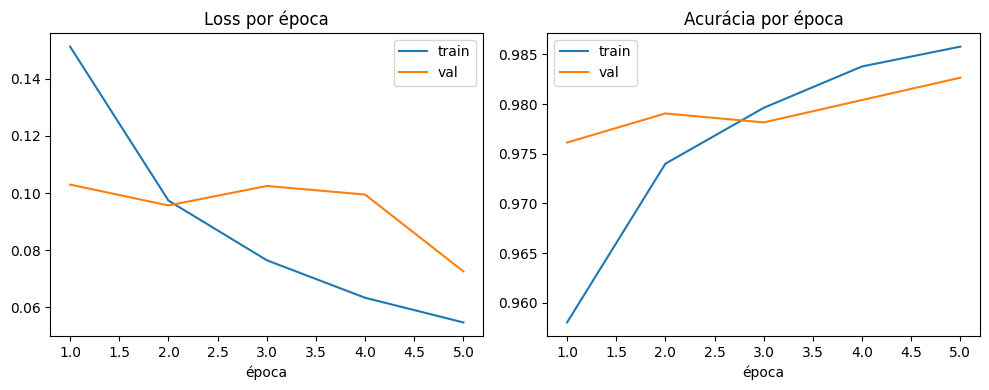

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='train')
plt.plot(range(1, len(val_losses)+1), val_losses, label='val')
plt.title('Loss por época')
plt.xlabel('época')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, len(train_accs)+1), train_accs, label='train')
plt.plot(range(1, len(val_accs)+1), val_accs, label='val')
plt.title('Acurácia por época')
plt.xlabel('época')
plt.legend()

plt.tight_layout()
plt.show()



# 10) Salvar modelo

In [ ]:
MODEL_DIR = Path('models')
MODEL_DIR.mkdir(exist_ok=True)
MODEL_PATH = MODEL_DIR / 'simple_cnn.pth'
torch.save({'model_state_dict': model.state_dict(), 'label_mapping': label_mapping}, MODEL_PATH)
print('Modelo salvo em', MODEL_PATH)



Modelo salvo em models/simple_cnn.pth


# 11) Parágrafo final: relato de execução e análise

## Relatos:
> Durante o desenvolvimento do projeto usamos o dataset "Fashion Product Images". As maiores dificuldades foram:

* lidar com o grande número de imagens e o desbalanceamento entre classes. Para mitigar isso selecionamos as top-K classes mais frequentes e aplicamos transforms (resize, normalização e flips). Utilizamos uma CNN simples de 3 blocos convolucionais e treinamos por 5 épocas. Observamos que a acurácia de validação é menor que a de treino, indicando possível overfitting leve; aplicamos dropout e early-stopping poderia ser usado. Ajustes de hiperparâmetros (aumentar dados, usar transfer learning com modelos pré-treinados) provavelmente melhorariam a performance.
